In [154]:
import warnings
warnings.filterwarnings('ignore')

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 1.

In [156]:
n_samples = 100
n_features = 4
centers = [[1, 1, 1, 1], [-1, -1, -1, -1], [-1, 1, -1, 1]]

X, y = make_blobs(n_samples=[n_samples]*3, centers=centers, n_features=n_features, random_state=52)

df = pd.DataFrame(X, columns=[f"feature_{i+1}" for i in range(n_features)])
df['class'] = y
df

,feature_1,feature_2,feature_3,feature_4,class
0,-0.449676,-1.539038,-2.360061,0.025620,1
1,2.152184,0.992702,1.694592,0.714296,0
2,-0.771277,-0.275741,-0.203485,-1.124583,1
3,-0.670041,1.320625,-2.256772,0.414556,2
4,-0.937026,0.495608,-1.132854,0.522501,2
...,...,...,...,...,...
295,1.176820,1.833297,1.916202,0.559942,0
296,1.839807,0.907654,1.191202,1.108656,0
297,-1.184181,0.270129,-0.573697,-1.770455,1
298,-2.475952,0.457379,-0.713976,0.715471,1


# 2.

In [157]:
corr = df.corr()
corr

,feature_1,feature_2,feature_3,feature_4,class
feature_1,1.000000,0.228121,0.469463,0.332017,-0.605731
feature_2,0.228121,1.000000,0.268765,0.415612,-0.042753
feature_3,0.469463,0.268765,1.000000,0.288598,-0.626927
feature_4,0.332017,0.415612,0.288598,1.000000,-0.103006
class,-0.605731,-0.042753,-0.626927,-0.103006,1.000000


In [158]:
for class_name, group in df.groupby('class'):
    print(f"\n\ncorr for class: {class_name}")
    print(group.drop('class', axis=1).corr())



corr for class: 0
           feature_1  feature_2  feature_3  feature_4
feature_1   1.000000   0.034459   0.040695  -0.049846
feature_2   0.034459   1.000000   0.104098   0.038138
feature_3   0.040695   0.104098   1.000000  -0.107233
feature_4  -0.049846   0.038138  -0.107233   1.000000


corr for class: 1
           feature_1  feature_2  feature_3  feature_4
feature_1   1.000000  -0.194626  -0.270292   0.049818
feature_2  -0.194626   1.000000   0.086390  -0.134348
feature_3  -0.270292   0.086390   1.000000   0.090771
feature_4   0.049818  -0.134348   0.090771   1.000000


corr for class: 2
           feature_1  feature_2  feature_3  feature_4
feature_1   1.000000  -0.157397  -0.045271   0.151404
feature_2  -0.157397   1.000000  -0.173001   0.024253
feature_3  -0.045271  -0.173001   1.000000  -0.007132
feature_4   0.151404   0.024253  -0.007132   1.000000


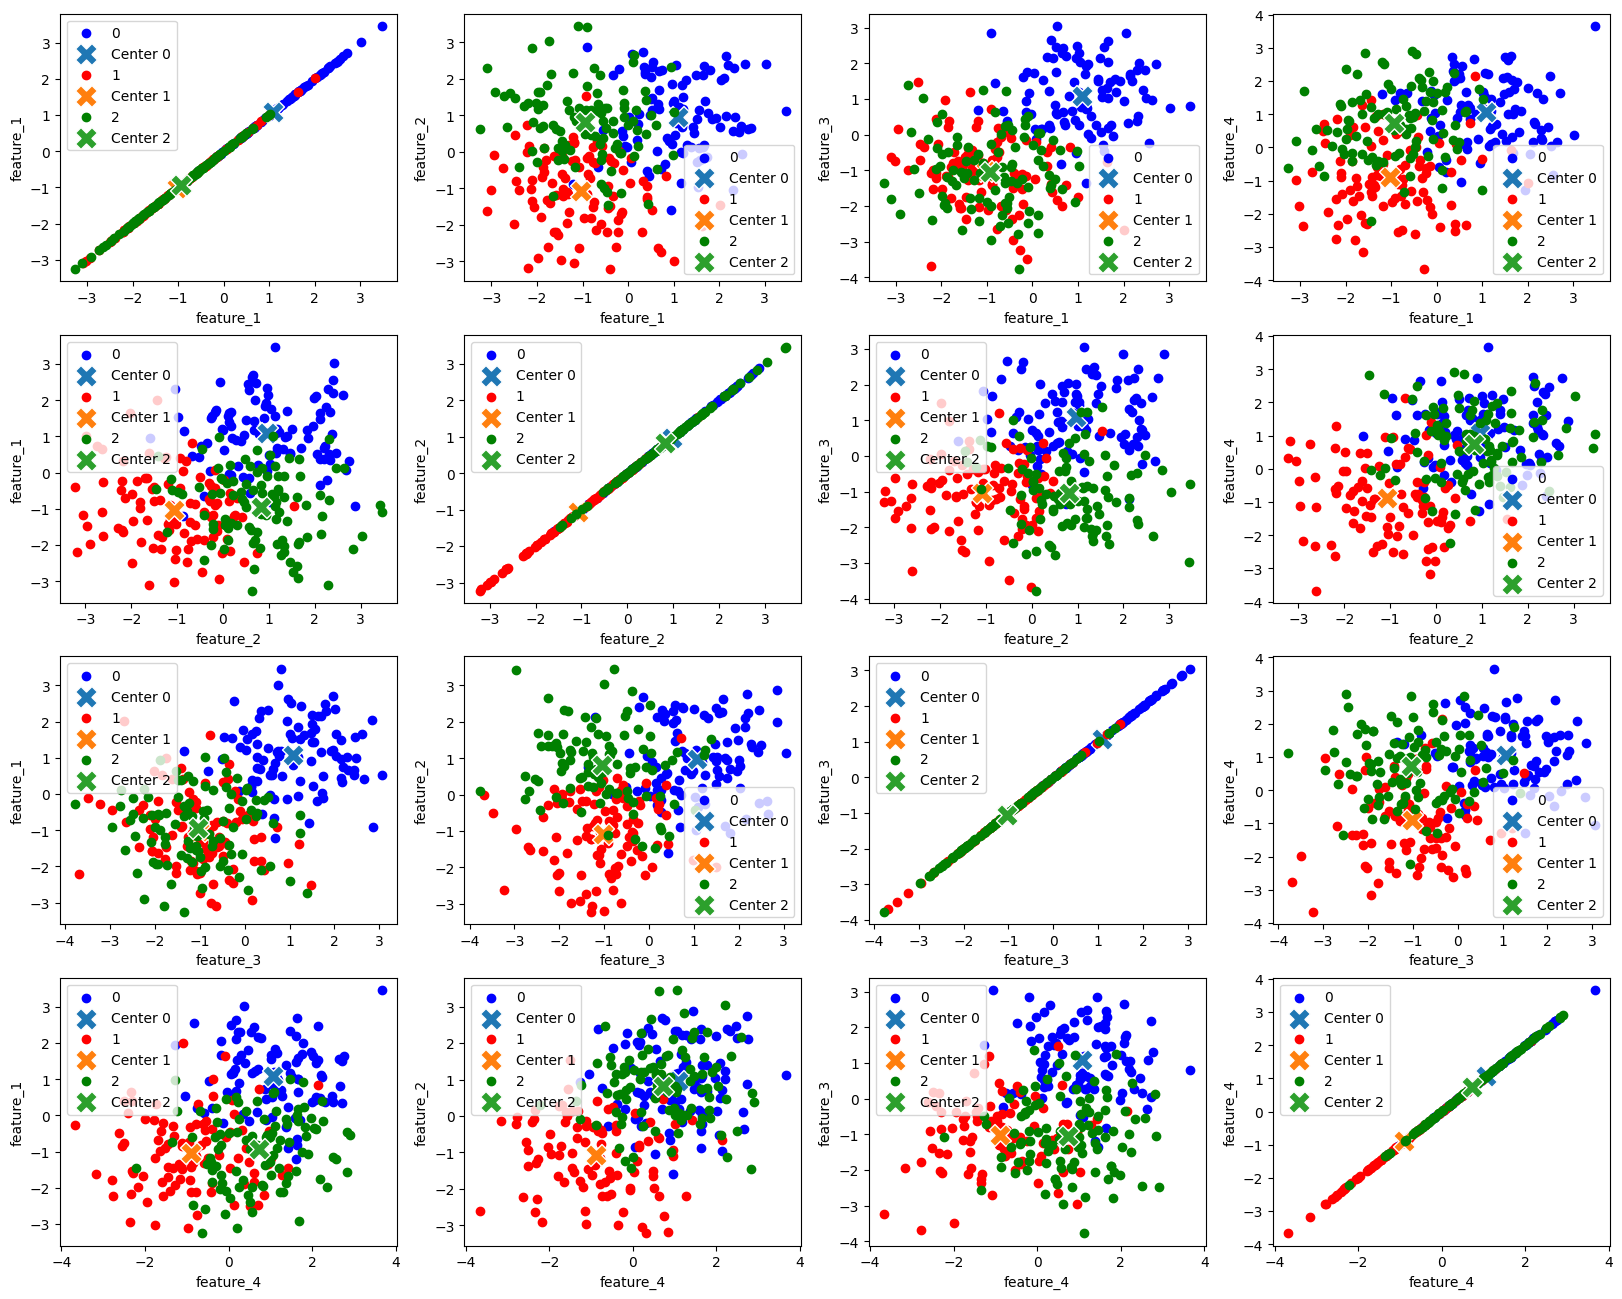

In [159]:
calculated_centers = df.groupby('class').mean()

plt.figure(figsize=(20, 16))
for i, feature_name1 in enumerate(df.drop('class', axis=1).columns):
    for j, feature_name2 in enumerate(df.drop('class', axis=1).columns):
        plt.subplot(4, 4, 4 * i + j + 1)
        plt.xlabel(feature_name1)
        plt.ylabel(feature_name2)
        dict_color = {0: 'blue', 1: 'red', 2: 'green'}
        for label in dict_color:
            plt.scatter(df[df['class'] == label][feature_name1], 
                        df[df['class'] == label][feature_name2], 
                        c=dict_color[label], label=label)
            
            # Центры
            plt.scatter(calculated_centers.loc[label, feature_name1], 
                        calculated_centers.loc[label, feature_name2], 
                        s=250, marker='X', edgecolor='white', label=f"Center {label}")
            
        plt.legend()
plt.show()

# 3.

In [160]:
B_5 = pd.DataFrame({
    "feature_1": [5],
    "feature_2": [-5],
    "feature_3": [5],
    "feature_4": [-5],
    "class": [0]
})
B_10 = pd.DataFrame({
    "feature_1": [10],
    "feature_2": [-10],
    "feature_3": [10],
    "feature_4": [-10],
    "class": [0]
})
B_20 = pd.DataFrame({
    "feature_1": [20],
    "feature_2": [-20],
    "feature_3": [20],
    "feature_4": [-20],
    "class": [0]
})
df_1_5 = pd.concat([df, B_5], ignore_index=True)
df_1_10 = pd.concat([df, B_10], ignore_index=True)
df_1_20 = pd.concat([df, B_20], ignore_index=True)
df_10_5 = pd.concat([df, pd.concat([B_5] * 10, ignore_index=True)], ignore_index=True)
df_10_10 = pd.concat([df, pd.concat([B_10] * 10, ignore_index=True)], ignore_index=True)
df_10_20 = pd.concat([df, pd.concat([B_20] * 10, ignore_index=True)], ignore_index=True)
df_100_5 = pd.concat([df, pd.concat([B_5] * 100, ignore_index=True)], ignore_index=True)
df_100_10 = pd.concat([df, pd.concat([B_10] * 100, ignore_index=True)], ignore_index=True)
df_100_20 = pd.concat([df, pd.concat([B_20] * 100, ignore_index=True)], ignore_index=True)

# 4.

In [161]:
feature = 'feature_1'
class_to_throw = 2
df_X_Y = df[[feature,'class']]
df_X_Y = df_X_Y[df_X_Y['class'] != class_to_throw]

df_1_5_X_Y = df_1_5[[feature,'class']]
df_1_5_X_Y = df_1_5_X_Y[df_1_5_X_Y['class'] != class_to_throw]

df_1_10_X_Y = df_1_10[[feature,'class']]
df_1_10_X_Y = df_1_10_X_Y[df_1_10_X_Y['class'] != class_to_throw]

df_1_20_X_Y = df_1_20[[feature,'class']]
df_1_20_X_Y = df_1_20_X_Y[df_1_20_X_Y['class'] != class_to_throw]

df_10_5_X_Y = df_10_5[[feature,'class']]
df_10_5_X_Y = df_10_5_X_Y[df_10_5_X_Y['class'] != class_to_throw]

df_10_10_X_Y = df_10_10[[feature,'class']]
df_10_10_X_Y = df_10_10_X_Y[df_10_10_X_Y['class'] != class_to_throw]

df_10_20_X_Y = df_10_20[[feature,'class']]
df_10_20_X_Y = df_10_20_X_Y[df_10_20_X_Y['class'] != class_to_throw]

df_100_5_X_Y = df_100_5[[feature,'class']]
df_100_5_X_Y = df_100_5_X_Y[df_100_5_X_Y['class'] != class_to_throw]

df_100_10_X_Y = df_100_10[[feature,'class']]
df_100_10_X_Y = df_100_10_X_Y[df_100_10_X_Y['class'] != class_to_throw]

df_100_20_X_Y = df_100_20[[feature,'class']]
df_100_20_X_Y = df_100_20_X_Y[df_100_20_X_Y['class'] != class_to_throw]

df_100_20_X_Y

,feature_1,class
0,-0.449676,1
1,2.152184,0
2,-0.771277,1
5,-0.067488,0
7,-0.139256,1
...,...,...
395,20.000000,0
396,20.000000,0
397,20.000000,0
398,20.000000,0


In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from sklearn.utils import resample
features = ['feature_1', 'class']

In [163]:
def task_4(df):
    X = df.drop('class', axis=1).reset_index(drop=True)
    y = df['class'].reset_index(drop=True)
    x_vals = np.linspace(X.min()-1, X.max()+1, 1000)

    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    y_vals_lin = lin_reg.predict(x_vals)

    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    y_vals_log = log_reg.predict_proba(x_vals)[:, 1]
    y_pred = log_reg.predict_proba(X)[:, 1]

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X, y, c=y, label='Точки', alpha=0.8)
    plt.plot(x_vals, y_vals_lin, color='green', label='Lin reg')
    plt.plot(x_vals, y_vals_log, color='blue', label='Log reg')
    plt.xlabel('feature 1')
    plt.ylabel('class')
    plt.ylim([-0.2, 1.2])
    plt.legend()

    #ROC
    plt.subplot(1, 2, 2)
    #np.random.seed(52)
    n_bootstrap = 1000
    fpr, tpr, thresholds = roc_curve(y, y_pred, )
    roc_auc = auc(fpr, tpr)

    # Точка, при трешхолде 0.5
    #idx = np.where(np.array(thresholds))[0]
    idx = len(thresholds) // 2
    print(idx)
    best_threshold = thresholds[idx]
    best_sen = tpr[idx]
    best_spe = 1 - fpr[idx]

    confidence_level = 0.95
    z_score = norm.ppf((1 + confidence_level) / 2) # Для доверительного

    aucs = []
    tprs = []
    for i in range(n_bootstrap):
        #X_r, y_r = resample(X, y, random_state=i)
        X_r, y_r = resample(X, y, replace=True)
        log_reg.fit(X_r, y_r)
        y_prob_r = log_reg.predict_proba(X_r)[:, 1]
        fpr_r, tpr_r, _ = roc_curve(y_r, y_prob_r)
        roc_auc_r = auc(fpr_r, tpr_r)
        aucs.append(roc_auc_r)
        tprs.append(np.interp(fpr, fpr_r, tpr_r)) #?

        if((i + 1) % 100 == 0):
            plt.plot(fpr_r, tpr_r, '--', alpha=0.5)

    mean_tpr = np.mean(tprs, axis=0)
    #mean_auc = auc(np.linspace(0, 1, 100), mean_tpr) #?
    mean_auc = np.mean(aucs)
    tpr_std = np.std(tprs, axis=0)
    std_auc = np.std(aucs) # Стандартное отклонение
    confidence_lower = max(0, mean_auc - z_score * std_auc) # Высчитываем доверительный интервал
    confidence_upper = min(1, mean_auc + z_score * std_auc) #
    #lower_tpr = np.percentile(tprs, (100 - confidence_lower) / 2, axis=0)
    #upper_tpr = np.percentile(tprs, 100 - (100 - confidence_lower) / 2, axis=0)

    plt.plot(fpr, tpr, label=f'ROC curve {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], '--', label='Baseline')
    plt.fill_between(fpr, np.maximum(0, mean_tpr - z_score * tpr_std), np.minimum(1, mean_tpr + z_score * tpr_std), color='b', alpha=0.2, label=f'{confidence_level}% CI')
    #plt.fill_between(fpr, np.maximum(0, lower_tpr), np.minimum(1, upper_tpr), color='b', alpha=0.2, label=f'{confidence_level}% CI')
    plt.scatter(1 - best_spe, best_sen, color='yellow', zorder=100, label=f'Spe-Sen point \nsen: {best_sen:.3} \nspe: {best_spe:.3}')
    print(f"confidens level = [{confidence_lower}/{confidence_upper}]")
    plt.legend(loc='lower right')

## df_X_Y

23
confidens level = [0.9058509941345333/0.971877584413433]


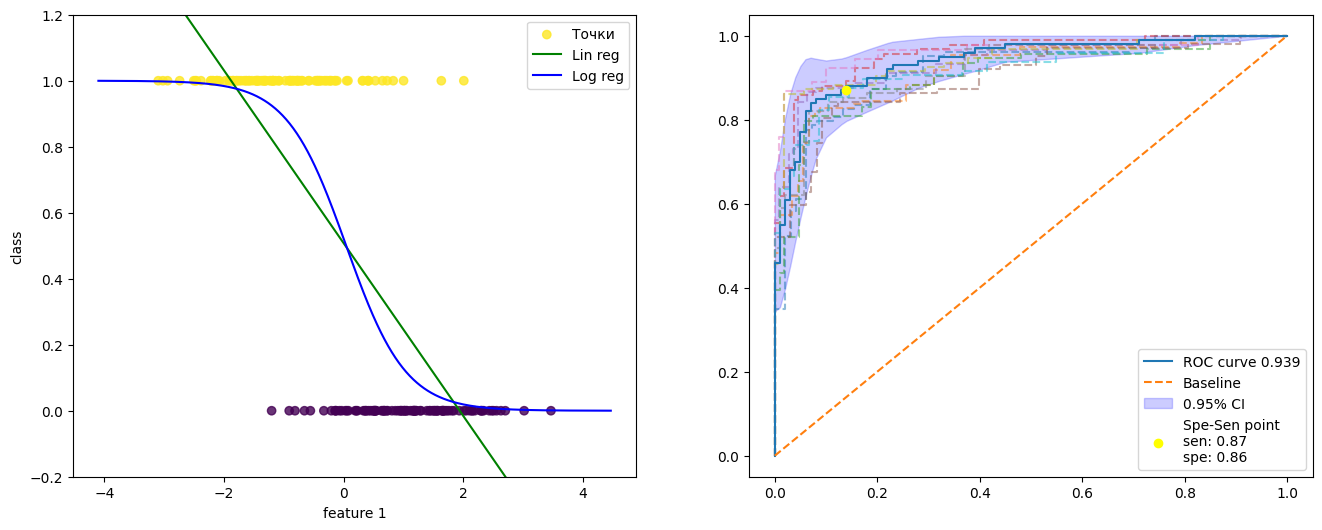

In [164]:
task_4(df_X_Y)

## df_1_5_X_Y

23
confidens level = [0.9079110158012832/0.9718434177512113]


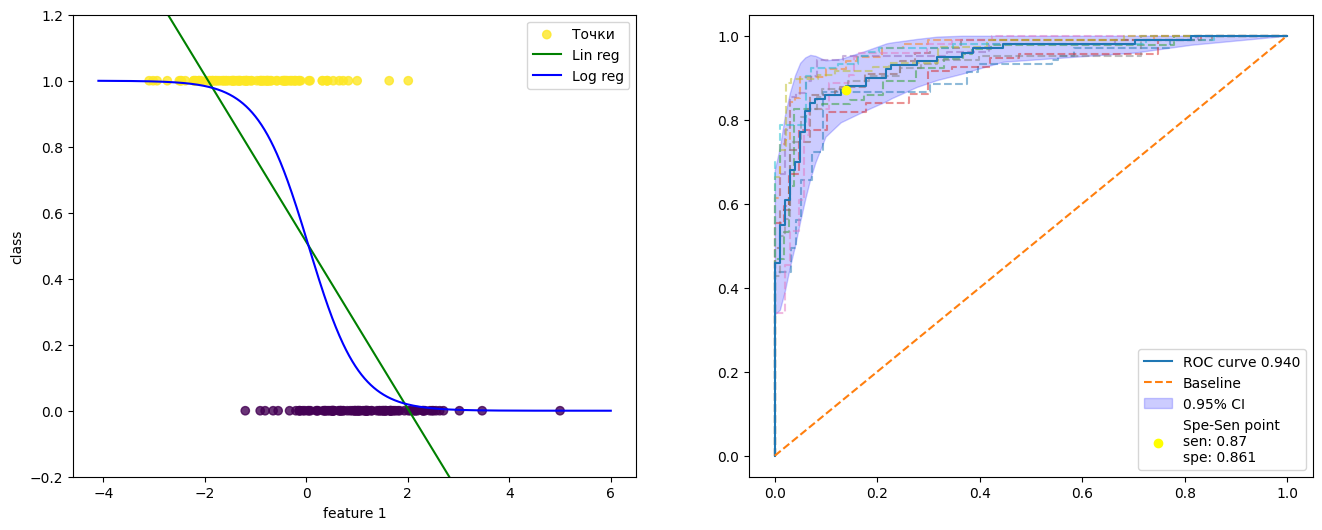

In [165]:
task_4(df_1_5_X_Y)

## df_1_10_X_Y

23
confidens level = [0.9071591340492856/0.9709129494431926]


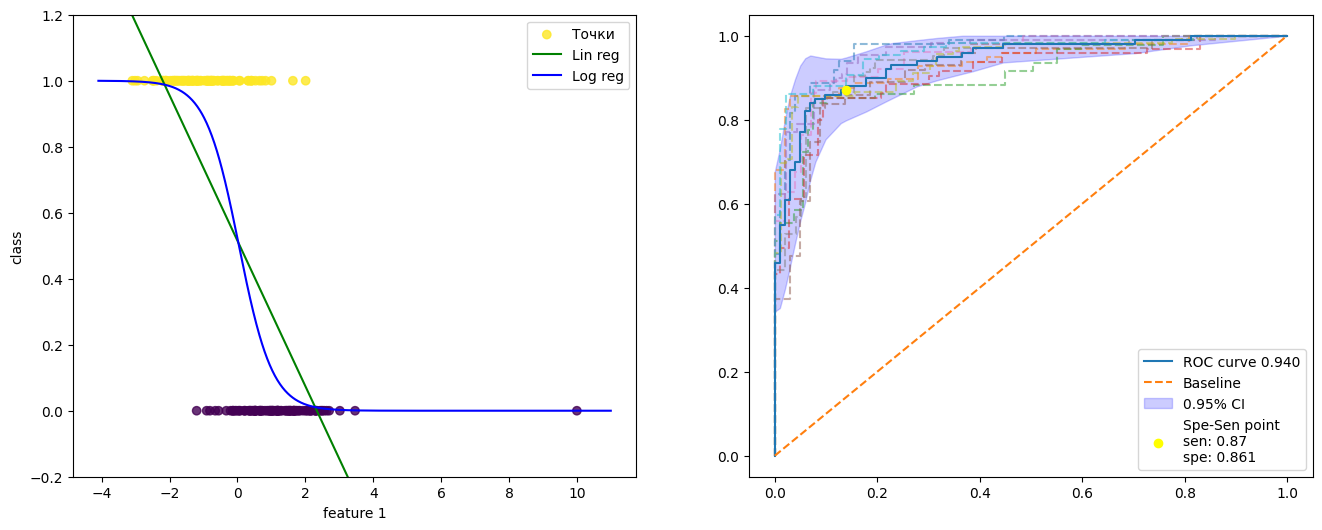

In [166]:
task_4(df_1_10_X_Y)

## df_1_20_X_Y

23
confidens level = [0.9081984766955089/0.9714923019570005]


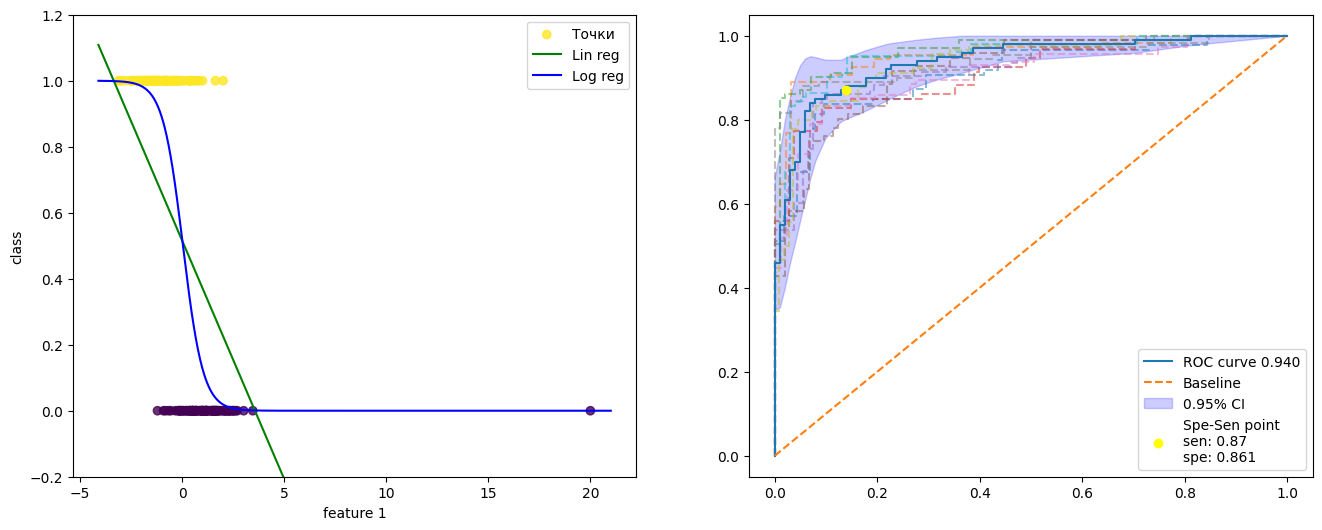

In [167]:
task_4(df_1_20_X_Y)

## df_10_5_X_Y

23
confidens level = [0.9128844583474361/0.9753853075203646]


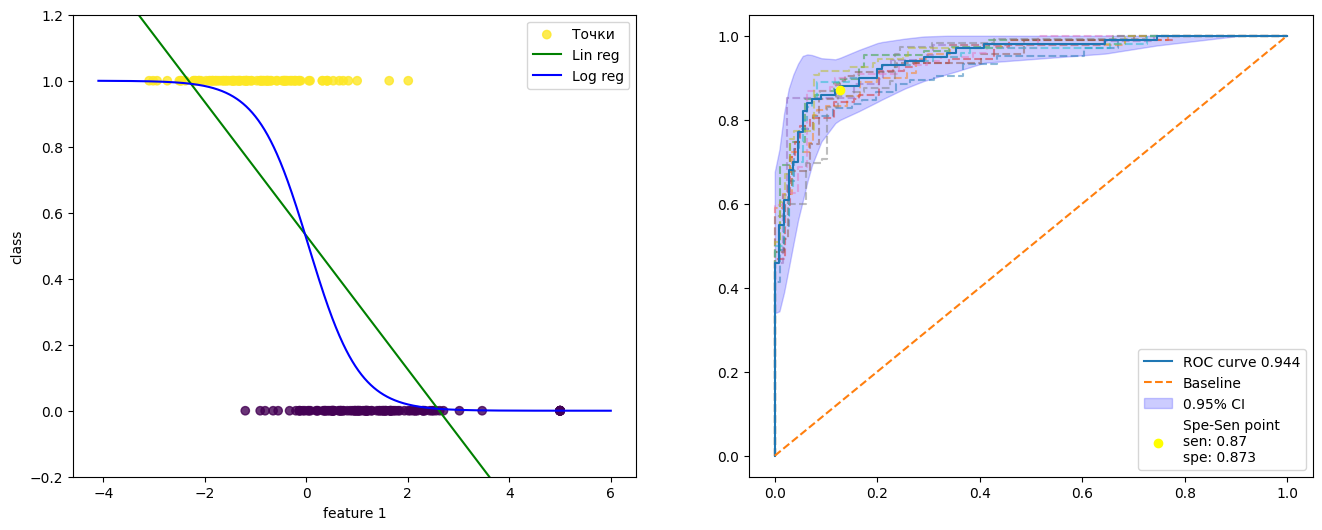

In [168]:
task_4(df_10_5_X_Y)

## df_10_10_X_Y

23
confidens level = [0.9115697337227322/0.9756256826707155]


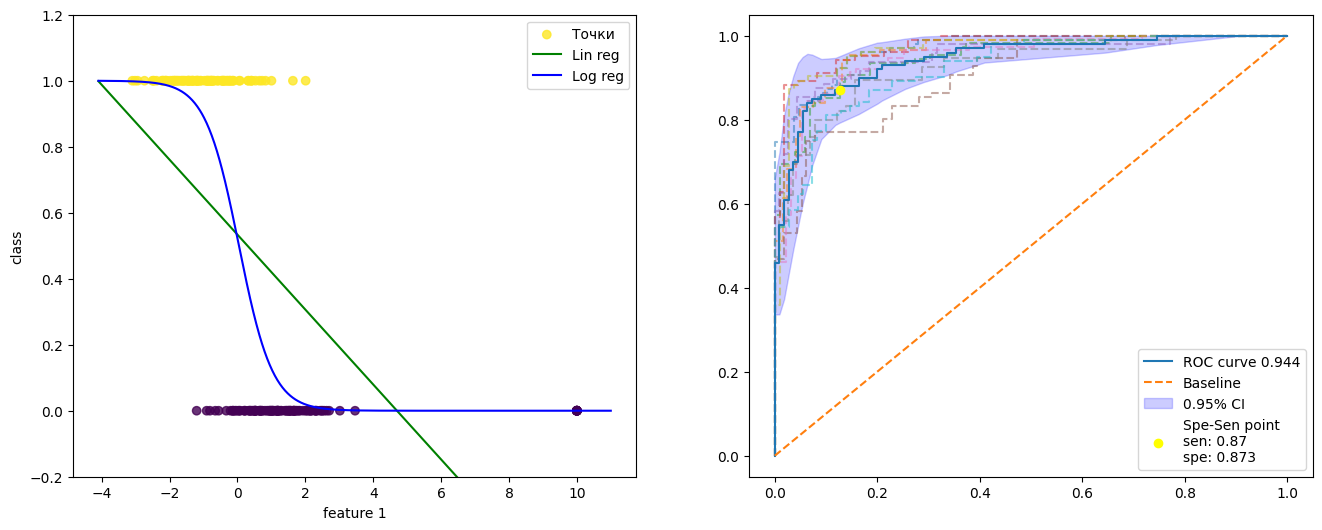

In [169]:
task_4(df_10_10_X_Y)

## df_10_20_X_Y

23
confidens level = [0.9147939218099225/0.974597393634241]


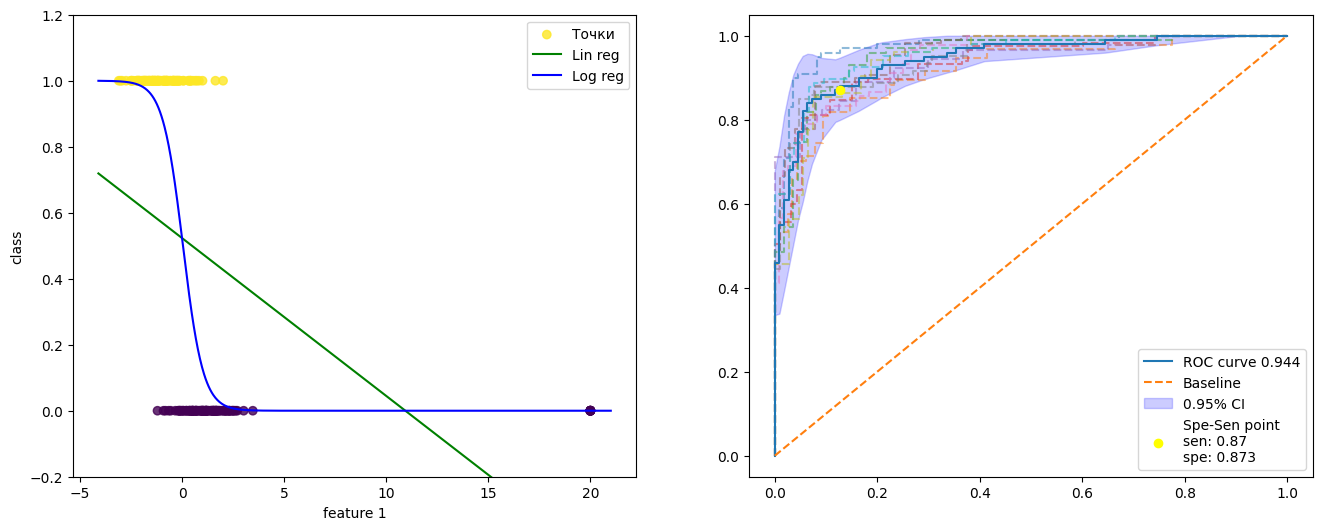

In [170]:
task_4(df_10_20_X_Y)

## df_100_5_X_Y

23
confidens level = [0.9528316849810561/0.9854768144407462]


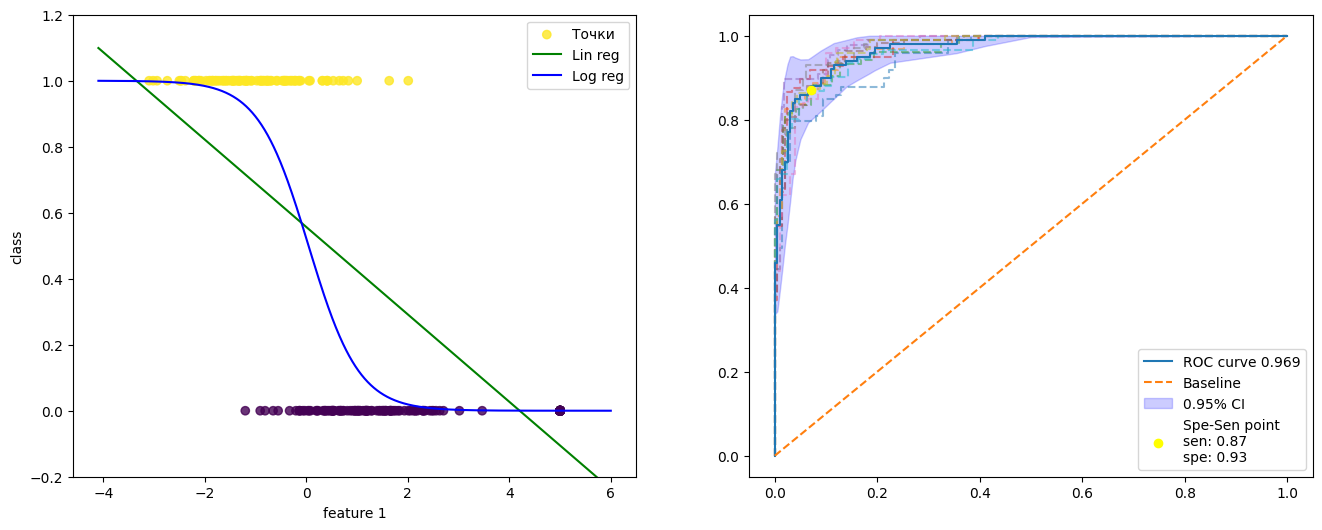

In [171]:
task_4(df_100_5_X_Y)

## df_100_10_X_Y

23
confidens level = [0.9531342858453226/0.986422730064123]


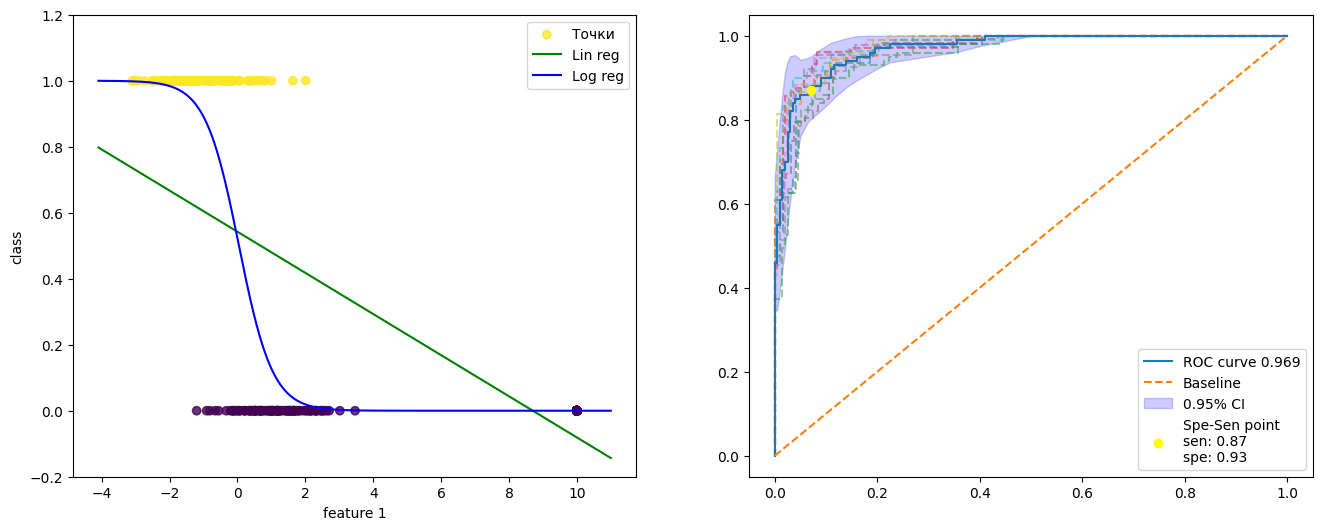

In [172]:
task_4(df_100_10_X_Y)

## df_100_20_X_Y

23
confidens level = [0.9526521151849353/0.9861466442527856]


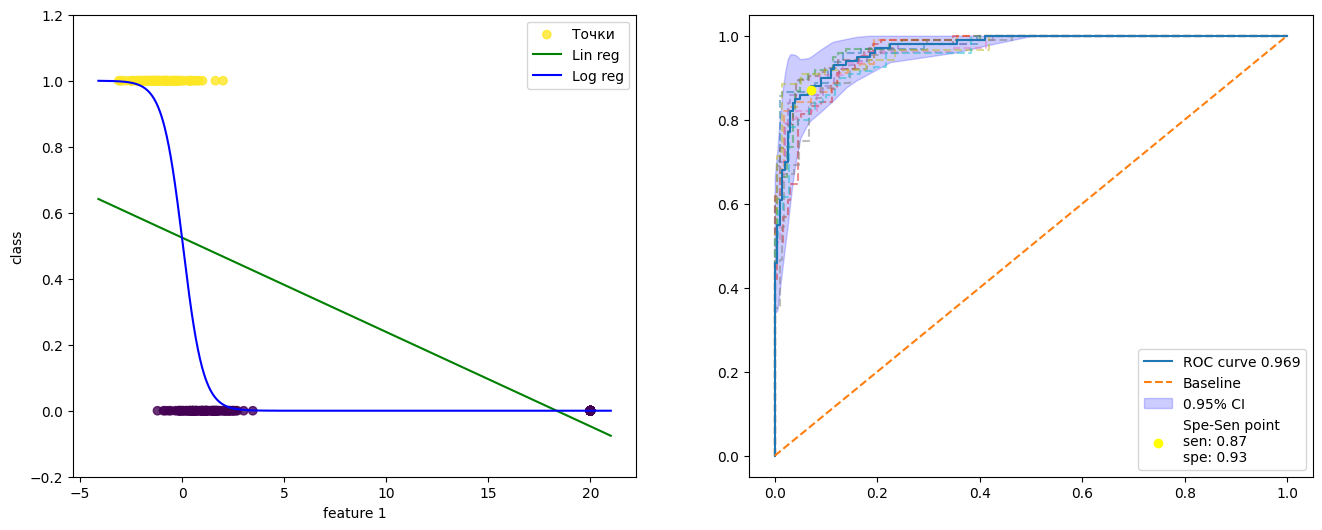

In [173]:
task_4(df_100_20_X_Y)

# 5.

In [174]:
def creale_logdf(df, df_name):
    lin_reg = LinearRegression()
    lin_reg.fit(df[df['class'] != 2].drop('class', axis=1).reset_index(drop=True), df[df['class'] != 2]['class'].reset_index(drop=True))
    coeff = lin_reg.coef_
    intercept = lin_reg.intercept_
    print(f"{df_name}: уравнение множественной линейной регрессии:")
    print(f"Y = {intercept:.3f}", end="")
    for coef, feature in zip(coeff, df.drop('class', axis=1).columns):
        print(f" + {coef:.3f} * {feature}", end="")# if coef >= 0 else " ")
    print("\n")
    logdf = pd.DataFrame()
    logdf['log_feature_1'] = lin_reg.predict(df[df['class'] != 2].drop('class', axis=1).reset_index(drop=True))
    logdf['class'] = df[df['class'] != 2]['class'].reset_index(drop=True)
    return logdf

In [175]:
logdf = creale_logdf(df, 'df')
logdf_1_5 = creale_logdf(df_1_5, 'df_1_5')
logdf_1_10 = creale_logdf(df_1_10, 'df_1_10')
logdf_1_20 = creale_logdf(df_1_20, 'df_1_20')
logdf_10_5 = creale_logdf(df_10_5, 'df_10_5')
logdf_10_10 = creale_logdf(df_10_10, 'df_10_10')
logdf_10_20 = creale_logdf(df_10_20, 'df_10_20')
logdf_100_5 = creale_logdf(df_100_5, 'df_100_5')
logdf_100_10 = creale_logdf(df_100_10, 'df_100_10')
logdf_100_20 = creale_logdf(df_100_20, 'df_100_20')

df: уравнение множественной линейной регрессии:
Y = 0.509 + -0.121 * feature_1 + -0.090 * feature_2 + -0.109 * feature_3 + -0.082 * feature_4

df_1_5: уравнение множественной линейной регрессии:
Y = 0.508 + -0.124 * feature_1 + -0.086 * feature_2 + -0.114 * feature_3 + -0.078 * feature_4

df_1_10: уравнение множественной линейной регрессии:
Y = 0.509 + -0.119 * feature_1 + -0.091 * feature_2 + -0.108 * feature_3 + -0.083 * feature_4

df_1_20: уравнение множественной линейной регрессии:
Y = 0.509 + -0.114 * feature_1 + -0.098 * feature_2 + -0.101 * feature_3 + -0.089 * feature_4

df_10_5: уравнение множественной линейной регрессии:
Y = 0.507 + -0.129 * feature_1 + -0.080 * feature_2 + -0.120 * feature_3 + -0.073 * feature_4

df_10_10: уравнение множественной линейной регрессии:
Y = 0.509 + -0.119 * feature_1 + -0.092 * feature_2 + -0.108 * feature_3 + -0.084 * feature_4

df_10_20: уравнение множественной линейной регрессии:
Y = 0.509 + -0.113 * feature_1 + -0.098 * feature_2 + -0.101 * 

# 6.

In [176]:
def task_4(df):
    X = df.drop('class', axis=1).reset_index(drop=True)
    y = df['class'].reset_index(drop=True)
    x_vals = np.linspace(X.min()-1, X.max()+1, 1000)

    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    y_vals_lin = lin_reg.predict(x_vals)

    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    y_vals_log = log_reg.predict_proba(x_vals)[:, 1]
    y_pred = log_reg.predict_proba(X)[:, 1]

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X, y, c=y, label='Точки', alpha=0.8)
    plt.plot(x_vals, y_vals_lin, color='green', label='Lin reg')
    plt.plot(x_vals, y_vals_log, color='blue', label='Log reg')
    plt.xlabel('feature 1')
    plt.ylabel('class')
    plt.ylim([-0.2, 1.2])
    plt.legend()

    #ROC
    plt.subplot(1, 2, 2)
    #np.random.seed(52)
    n_bootstrap = 1000
    fpr, tpr, thresholds = roc_curve(y, y_pred, )
    roc_auc = auc(fpr, tpr)

    # Точка, при трешхолде 0.5
    #idx = np.where(np.array(thresholds))[0]
    idx = len(thresholds) // 2
    print(idx)
    best_threshold = thresholds[idx]
    best_sen = tpr[idx]
    best_spe = 1 - fpr[idx]

    confidence_level = 0.95
    z_score = norm.ppf((1 + confidence_level) / 2) # Для доверительного

    aucs = []
    tprs = []
    for i in range(n_bootstrap):
        #X_r, y_r = resample(X, y, random_state=i)
        X_r, y_r = resample(X, y, replace=True)
        log_reg.fit(X_r, y_r)
        y_prob_r = log_reg.predict_proba(X_r)[:, 1]
        fpr_r, tpr_r, _ = roc_curve(y_r, y_prob_r)
        roc_auc_r = auc(fpr_r, tpr_r)
        aucs.append(roc_auc_r)
        tprs.append(np.interp(fpr, fpr_r, tpr_r)) #?

        if((i + 1) % 100 == 0):
            plt.plot(fpr_r, tpr_r, '--', alpha=0.5)

    mean_tpr = np.mean(tprs, axis=0)
    #mean_auc = auc(np.linspace(0, 1, 100), mean_tpr) #?
    mean_auc = np.mean(aucs)
    tpr_std = np.std(tprs, axis=0)
    std_auc = np.std(aucs) # Стандартное отклонение
    confidence_lower = max(0, mean_auc - z_score * std_auc) # Высчитываем доверительный интервал
    confidence_upper = min(1, mean_auc + z_score * std_auc) #
    #lower_tpr = np.percentile(tprs, (100 - confidence_lower) / 2, axis=0)
    #upper_tpr = np.percentile(tprs, 100 - (100 - confidence_lower) / 2, axis=0)

    plt.plot(fpr, tpr, label=f'ROC curve {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], '--', label='Baseline')
    plt.fill_between(fpr, np.maximum(0, mean_tpr - z_score * tpr_std), np.minimum(1, mean_tpr + z_score * tpr_std), color='b', alpha=0.2, label=f'{confidence_level}% CI')
    #plt.fill_between(fpr, np.maximum(0, lower_tpr), np.minimum(1, upper_tpr), color='b', alpha=0.2, label=f'{confidence_level}% CI')
    plt.scatter(1 - best_spe, best_sen, color='yellow', zorder=100, label=f'Spe-Sen point \nsen: {best_sen:.3} \nspe: {best_spe:.3}')
    print(f"confidens level = [{confidence_lower}/{confidence_upper}]")
    plt.legend(loc='lower right')

## df_X_Y

4
confidens level = [0.9955697719655121/1]


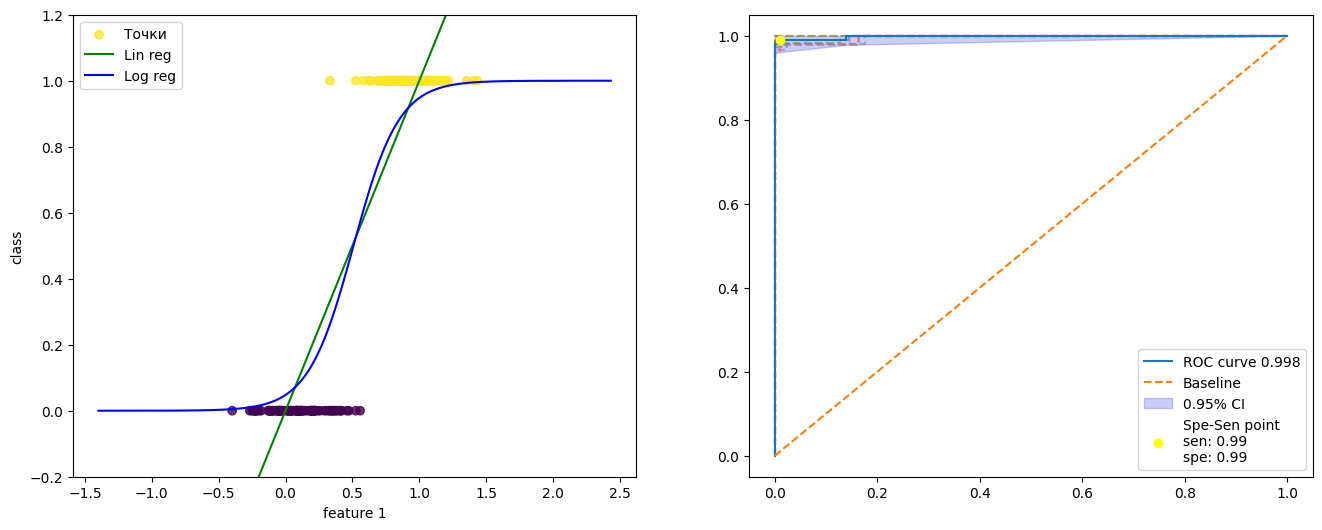

In [177]:
task_4(logdf)

## df_1_5_X_Y

4
confidens level = [0.9954921329297619/1]


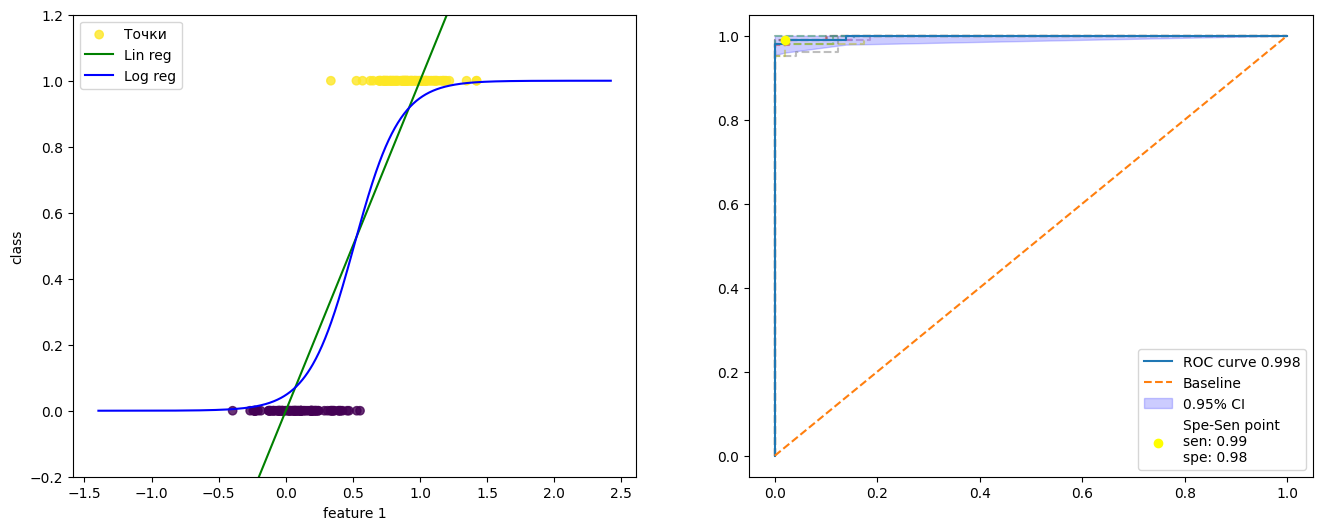

In [178]:
task_4(logdf_1_5)

## df_1_10_X_Y

4
confidens level = [0.9955184346526114/1]


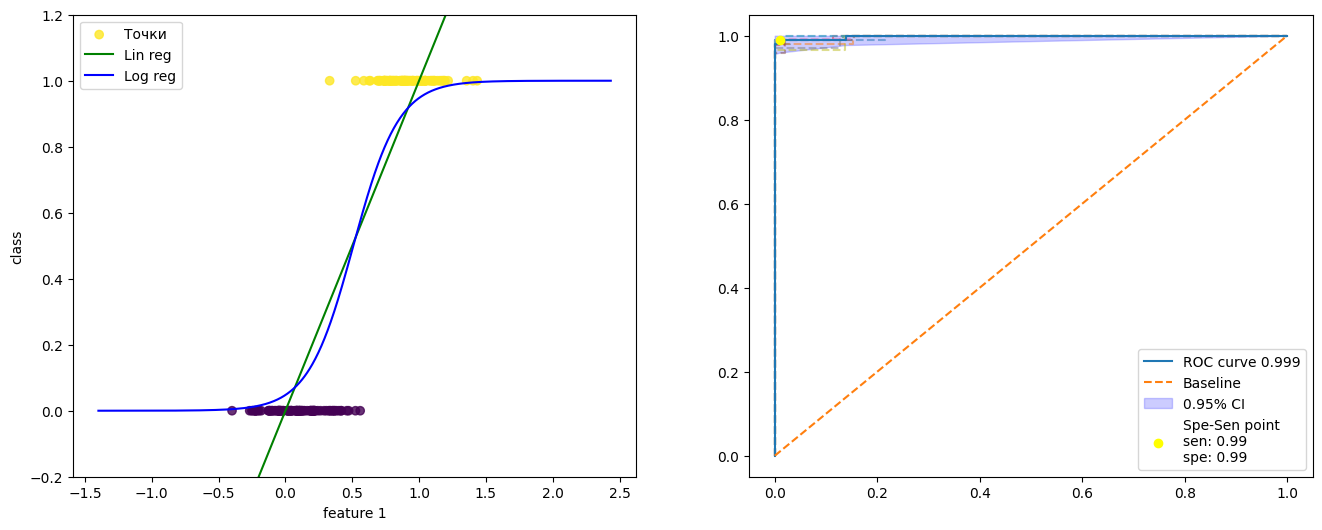

In [179]:
task_4(logdf_1_10)

## df_1_20_X_Y

4
confidens level = [0.9957604035018363/1]


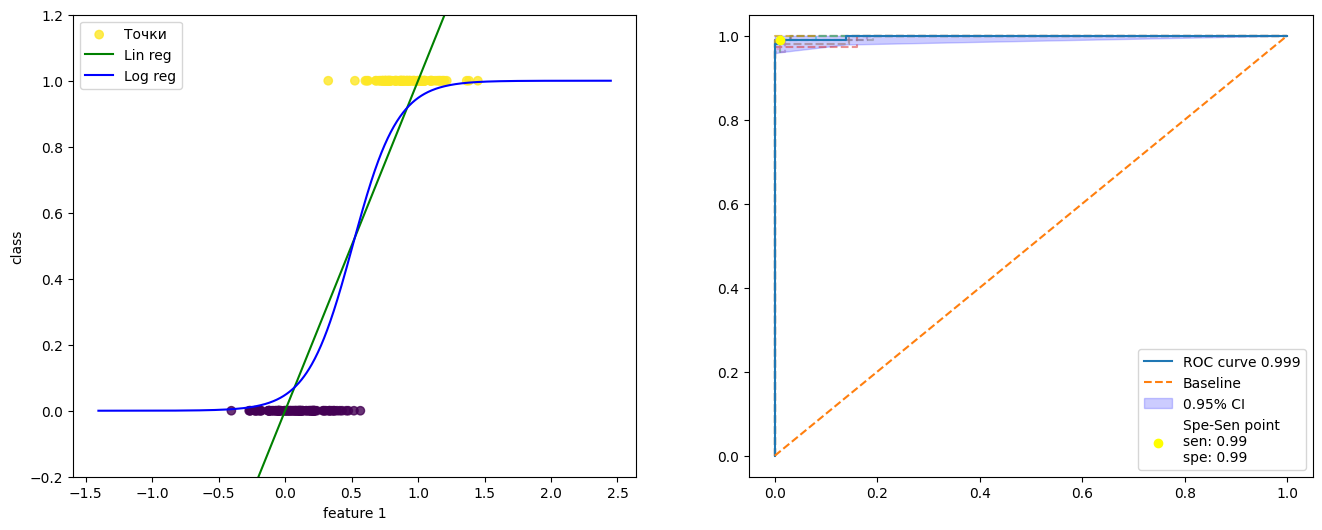

In [180]:
task_4(logdf_1_20)

## df_10_5_X_Y

5
confidens level = [0.9960768148203235/1]


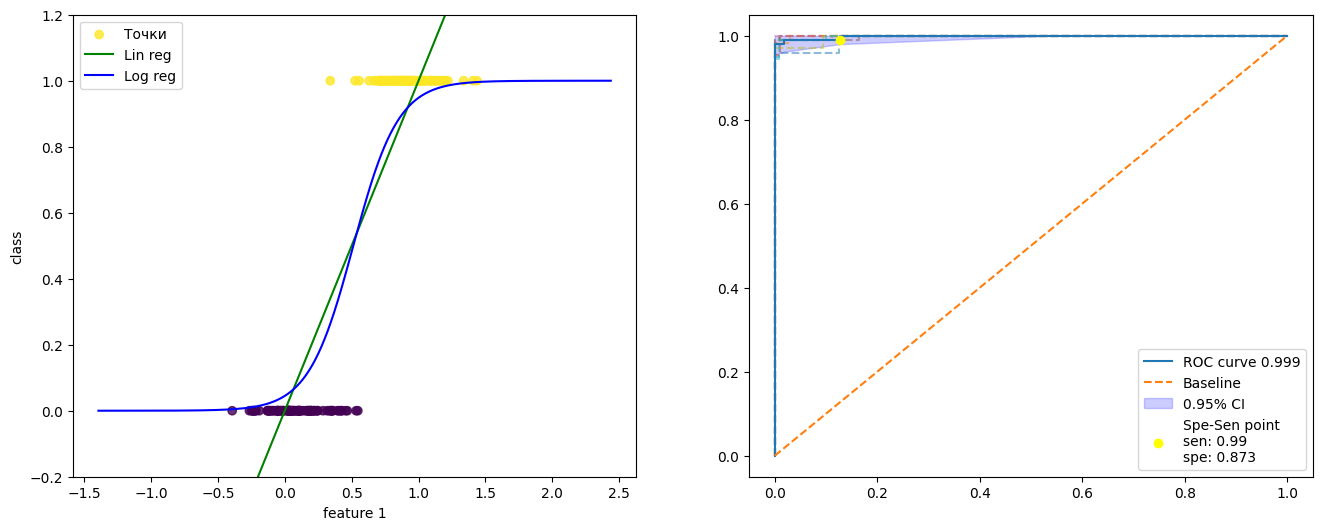

In [181]:
task_4(logdf_10_5)

## df_10_10_X_Y

5
confidens level = [0.995837051584915/1]


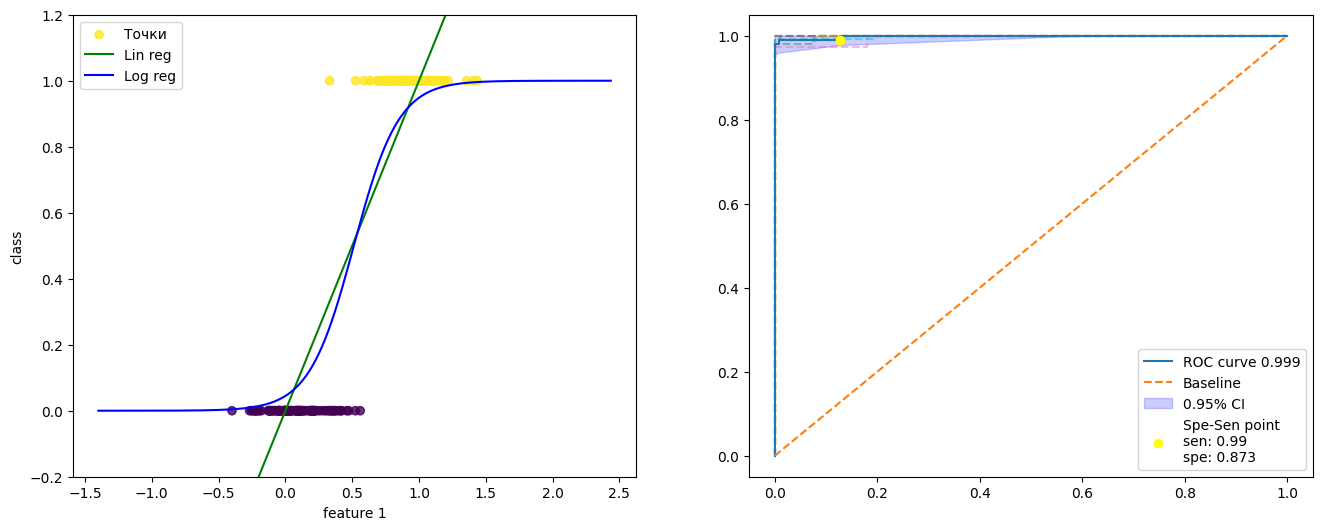

In [182]:
task_4(logdf_10_10)

## df_10_20_X_Y

5
confidens level = [0.9960044829774731/1]


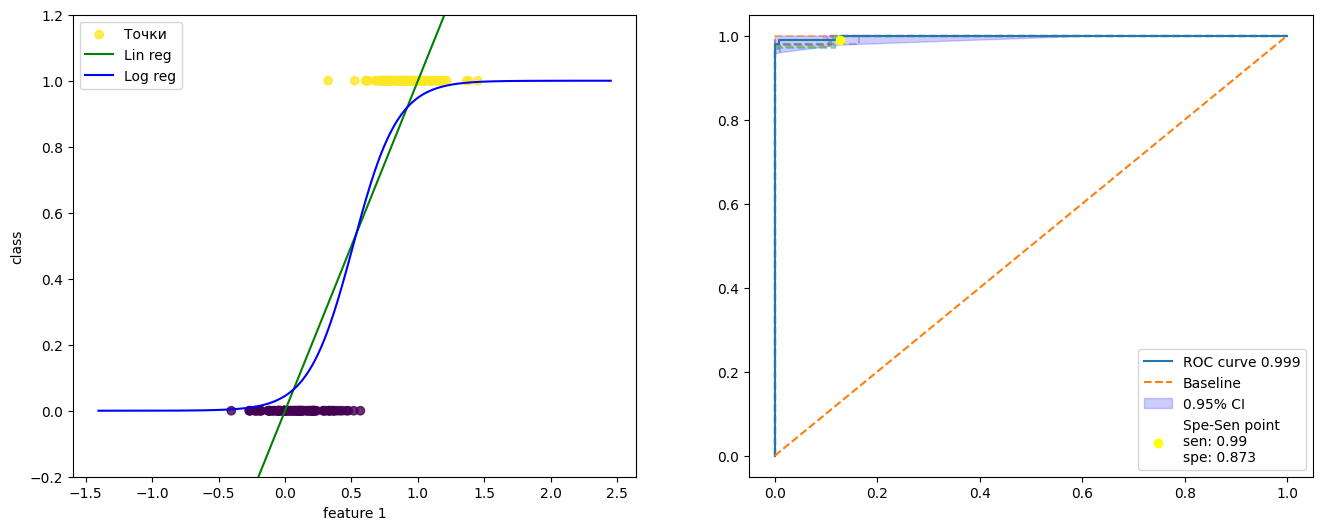

In [183]:
task_4(logdf_10_20)

## df_100_5_X_Y

5
confidens level = [0.9978273111458391/1]


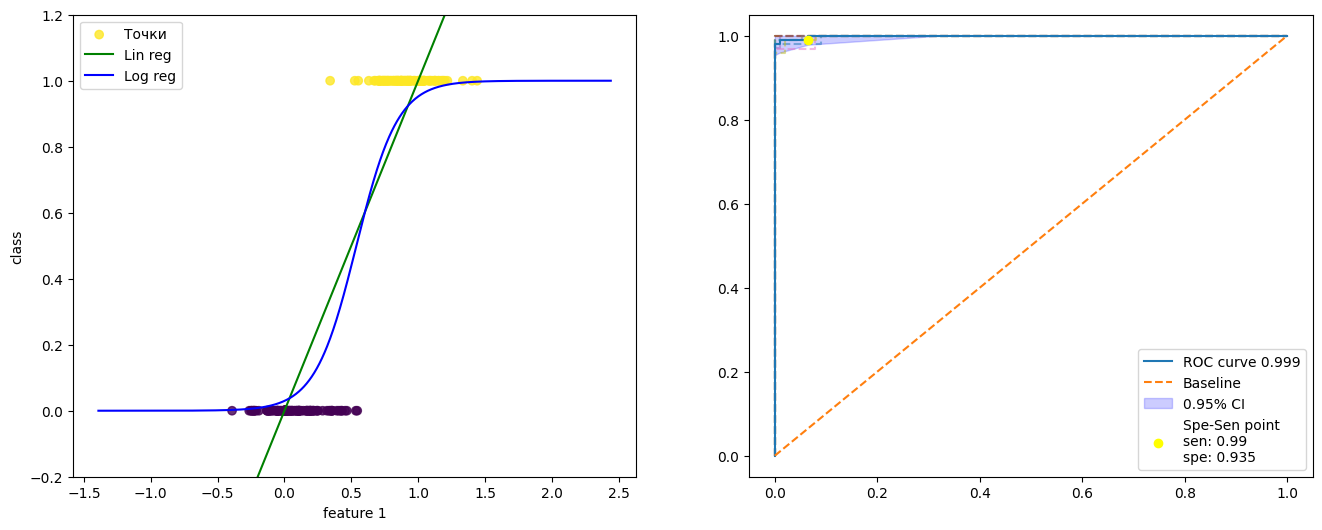

In [184]:
task_4(logdf_100_5)

## df_100_10_X_Y

5
confidens level = [0.9977602133043978/1]


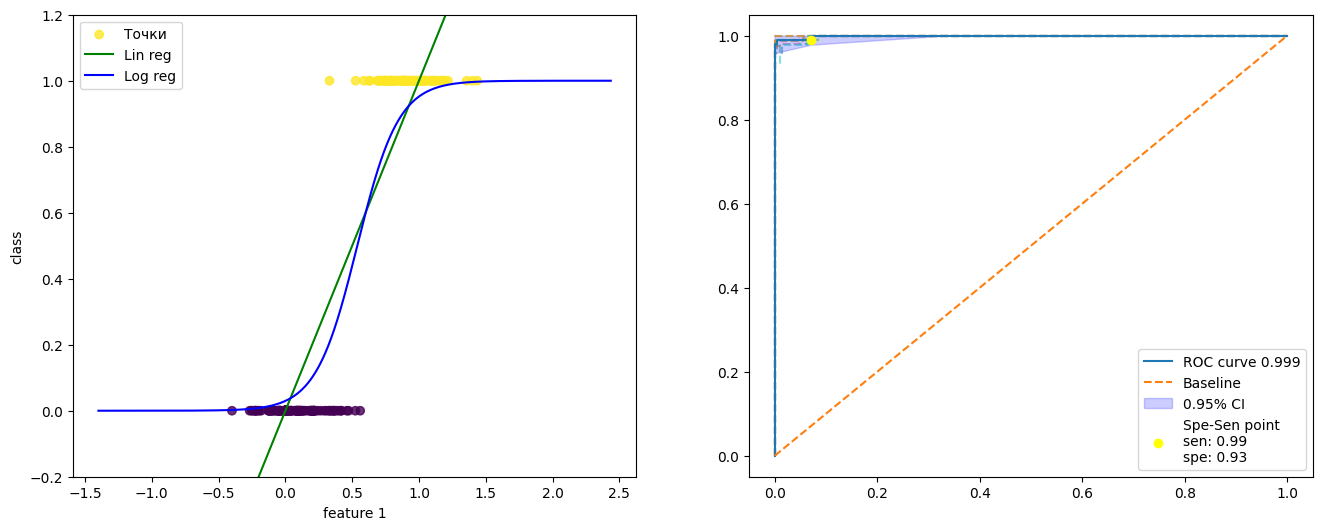

In [185]:
task_4(logdf_100_10)

## df_100_20_X_Y

5
confidens level = [0.997880072320335/1]


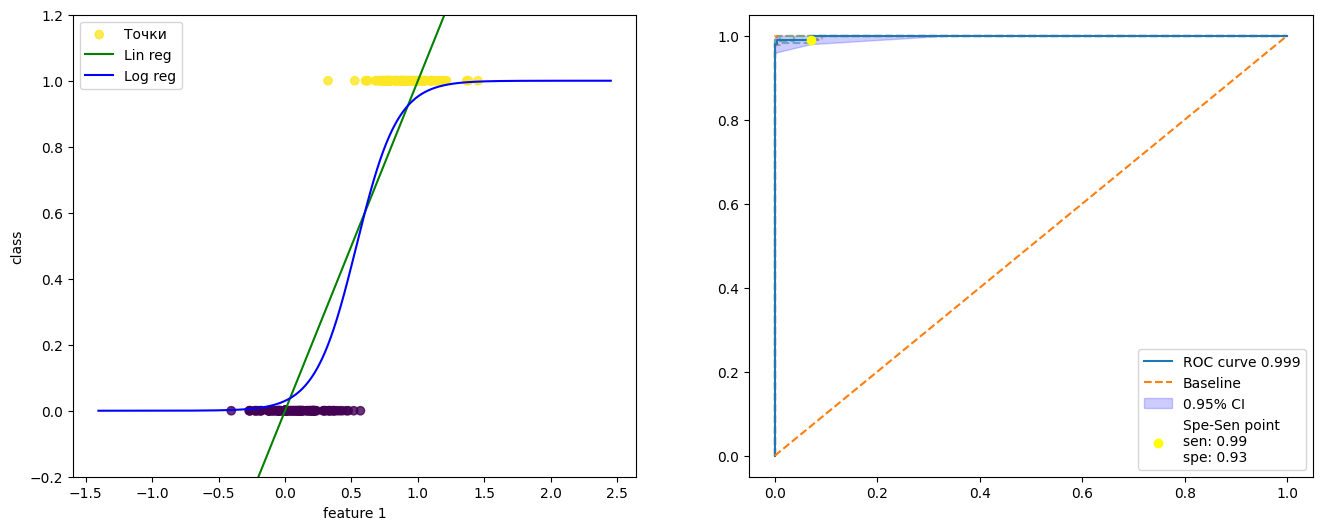

In [186]:
task_4(logdf_100_20)

# 7.

## df_10_5

In [187]:
from matplotlib.lines import Line2D
log_reg = LogisticRegression()
log_reg.fit(df_10_5.drop('class', axis=1).reset_index(drop=True), df_10_5['class'].reset_index(drop=True))
df_10_5

,feature_1,feature_2,feature_3,feature_4,class
0,-0.449676,-1.539038,-2.360061,0.025620,1
1,2.152184,0.992702,1.694592,0.714296,0
2,-0.771277,-0.275741,-0.203485,-1.124583,1
3,-0.670041,1.320625,-2.256772,0.414556,2
4,-0.937026,0.495608,-1.132854,0.522501,2
...,...,...,...,...,...
305,5.000000,-5.000000,5.000000,-5.000000,0
306,5.000000,-5.000000,5.000000,-5.000000,0
307,5.000000,-5.000000,5.000000,-5.000000,0
308,5.000000,-5.000000,5.000000,-5.000000,0


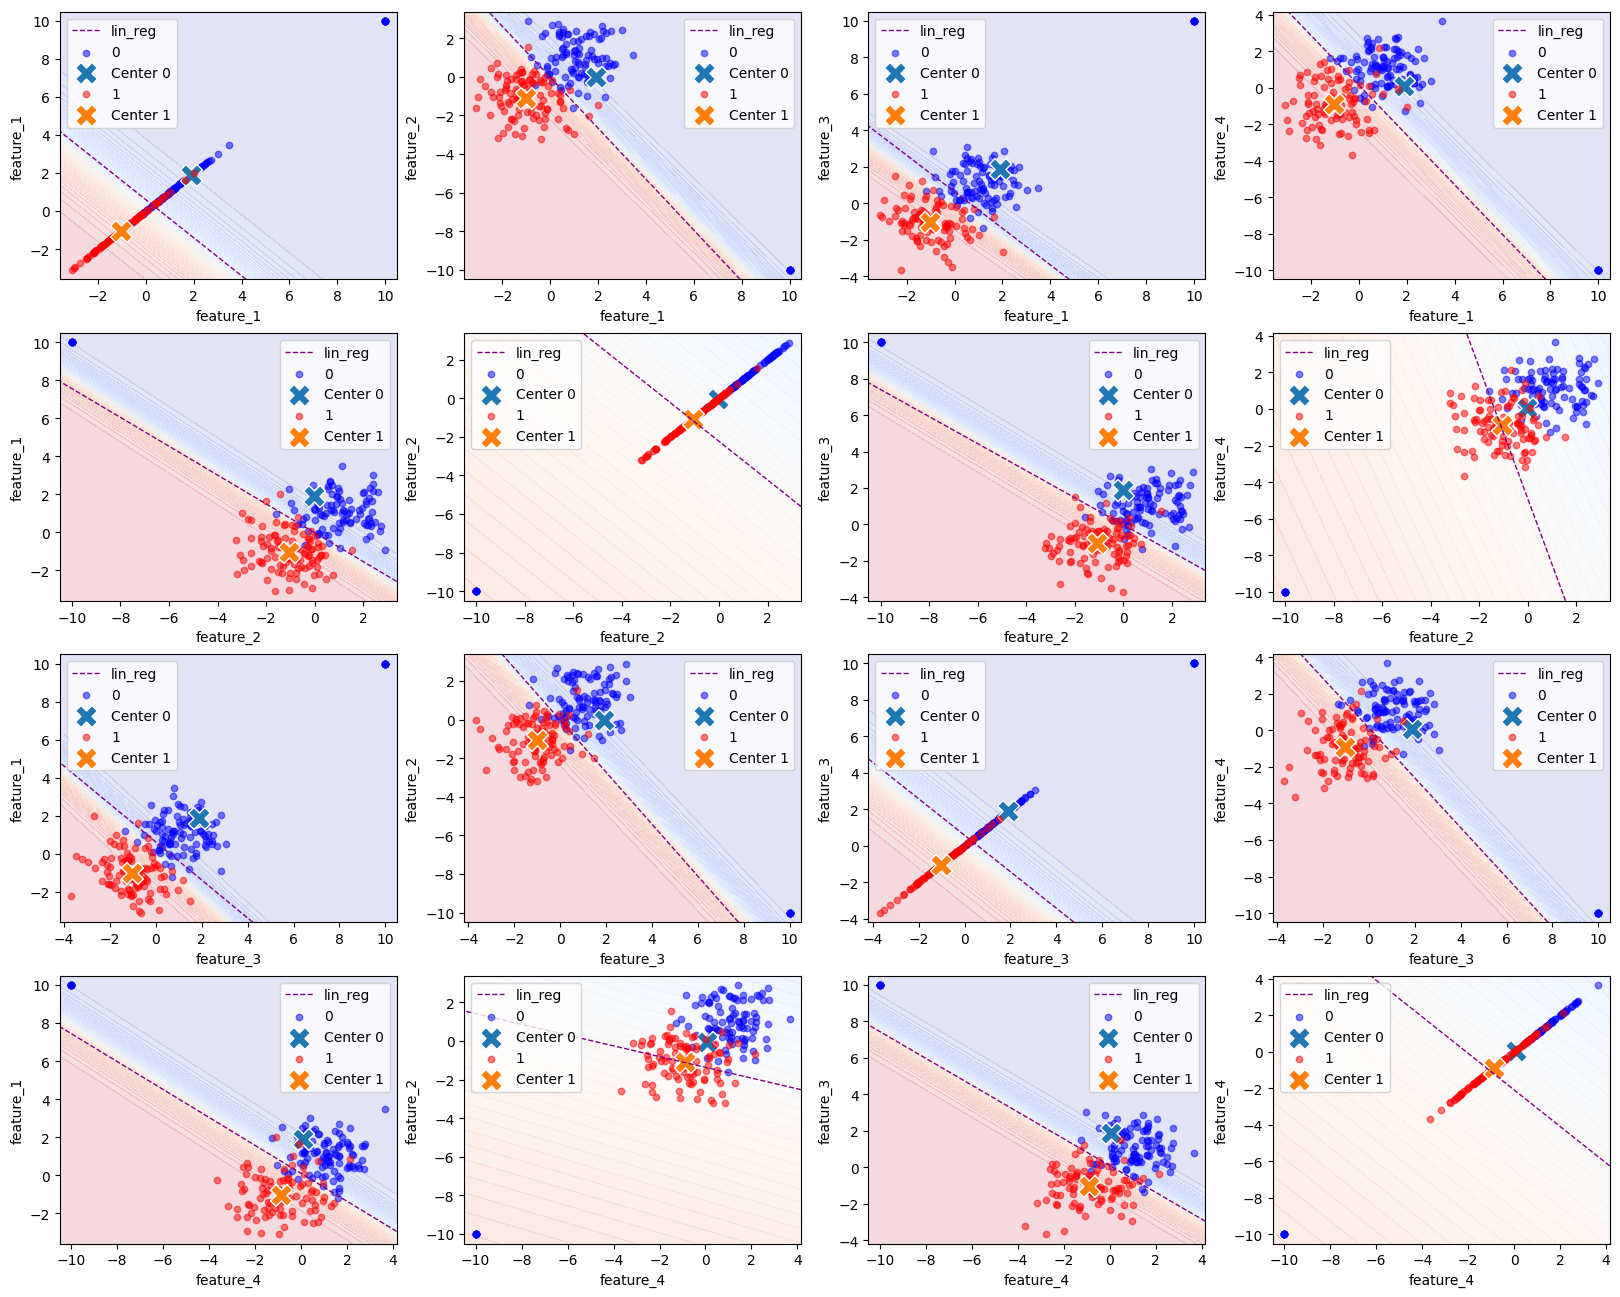

In [189]:
my_df = df_10_10

calculated_centers = my_df.groupby('class').mean()

## Уровни для множественной линейной регресии
levels_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#levels = [0.25, 0.5, 0.75]
levels = [0.5]

X = my_df[my_df['class'] != 2].drop('class', axis=1).reset_index(drop=True)
y = my_df[my_df['class'] != 2]['class'].reset_index(drop=True)

log_reg = LogisticRegression()
linear_reg = LinearRegression()

plt.figure(figsize=(20, 16))
for i, feature_name1 in enumerate(X.columns):
    for j, feature_name2 in enumerate(X.columns):
        plt.subplot(4, 4, 4 * i + j + 1)
        log_reg.fit(X[[feature_name1, feature_name2]], y)
        min_x, max_x = X[feature_name1].min() - 0.5, X[feature_name1].max() + 0.5
        min_y, max_y = X[feature_name2].min() - 0.5, X[feature_name2].max() + 0.5
        xx, yy = np.meshgrid(
            np.arange(min_x, max_x, 0.02),
            np.arange(min_y, max_y, 0.02)
        )
        Z = log_reg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.15, levels=np.linspace(0, 1, 50), cmap='coolwarm',)

        #линии множественной линейной регрессии 
        linear_reg.fit(X[[feature_name1, feature_name2]], y)
        Z_linear = linear_reg.predict(np.c_[xx.ravel(), yy.ravel()])
        Z_linear = Z_linear.reshape(xx.shape)
        plt.contour(xx, yy, Z_linear, colors='purple', levels=levels, linestyles='--', linewidths=1.0)
        #Создаем объект для легенды
        plt.plot([0, 0], [0, 0], color='purple', linestyle='--', linewidth=1.0, label='lin_reg')

        

        plt.xlabel(feature_name1)
        plt.ylabel(feature_name2)
        dict_color = {0: 'blue', 1: 'red'}#, 2: 'green'}
        for label in dict_color:
            plt.scatter(
                X[y == label][feature_name1], 
                X[y == label][feature_name2], 
                c=dict_color[label], label=label, alpha=0.5, s=21
            )
            
            # Центры
            plt.scatter(
                calculated_centers.loc[label, feature_name1], 
                calculated_centers.loc[label, feature_name2], 
                s=250, marker='X', edgecolor='white', label=f"Center {label}"
            )
        plt.legend()
plt.show()